* Load Sentinel 2 tile geometries which are axis aligned rectangles (property `utmWkt`) in a UTM coordinate system (property `epsg`).
* Crop the UTM polygons by 4890 m on all sides.
* Figure out the UTM zone based on the EPSG

In [1]:
import json
import numpy as np
from pyproj import Transformer
from shapely import wkt
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, LineString, box, mapping
from shapely.plotting import plot_polygon
from shapely.geometry.polygon import orient
from shapely.ops import unary_union
from tqdm import tqdm
import networkx as nx
import geopandas as gpd
from shapely.strtree import STRtree
from matplotlib import pyplot as plt

def clean_geometry(geom):
    """
    Removes non-polygon geometries and polygons with zero area from a Shapely geometry.
    Returns a cleaned Polygon or MultiPolygon.
    """
    def extract_valid_polygons(g):
        if g.is_empty:
            return []
        elif isinstance(g, Polygon):
            return [g] if g.area > 0 else []
        elif isinstance(g, (MultiPolygon, GeometryCollection)):
            polygons = []
            for part in g.geoms:
                polygons.extend(extract_valid_polygons(part))
            return polygons
        else:
            return []  # Discard LineString, Point, etc.

    valid_polygons = extract_valid_polygons(geom)

    if not valid_polygons:
        return Polygon()  # Return empty polygon if nothing remains
    elif len(valid_polygons) == 1:
        return valid_polygons[0]
    else:
        return MultiPolygon(valid_polygons)

# The known minimum overlap (m) between Sentinel-2 tiles when they are in the same UTM zone
min_overlap = 9780

# Overlap detection threshold (m)
max_overlap = 200

# Maximum number of points in each polygon, in densification. This is not a target but a threshold for raising an error.
max_points = 2000

# Approximate resolution (m), in densification
approx_resolution = 1

# Precision of densified polygons, in binary digits. This is to ensure equivalent rounding of regular and +-360 deg longitude clone tiles
densified_binary_precision = 30

# Load GeoJSON
with open("3rdparty/sentinel-2-grid/grid.geojson") as f:
    geojson_data = json.load(f)

# Save a prettified copy of the input GeoJSON
with open("3rdparty/sentinel-2-grid/grid_pretty.geojson", "w") as f:
    json.dump(geojson_data, f, indent=2)

# Tiles dictionary with the structure you want
tiles = {}
epsg_to_tiles = {}

to_wgs84 = {}
from_wgs84 = {}


print("Loading tile geometries")
for feature in tqdm(geojson_data.get("features", [])):
#for feature in tqdm(filter(lambda a: a["properties"]["id"][:2] in ("30", "31", "32", "33", "34", "35", "36", "37", "38"), geojson_data.get("features", []))):
    props = feature.get("properties", {})
    feature_id = props.get("id") or props.get("name") or "unknown"

    # Extract EPSG code (string)
    epsg_code = props.get("epsg")

    # Create UTM <-> WGS84 transforms
    utm_zone = int(epsg_code[-2:])
    if epsg_code not in to_wgs84:
        try:
            epsg_int = int(epsg_code)
            to_wgs84[epsg_code] = Transformer.from_crs(f"EPSG:{epsg_int}", "EPSG:4326", always_xy=True).transform
            from_wgs84[epsg_code] = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_int}", always_xy=True).transform
        except ValueError:
            print(f"Invalid EPSG code: {epsg_code}")

    # Parse the UTM polygon from utmWkt if available. These happen to be multipolygons with one element.
    utm_polygon = None
    utm_wkt = props.get("utmWkt")
    if utm_wkt:
        try:
            utm_geom = wkt.loads(utm_wkt)
            # Unwrap single-polygon multipolygons
            if utm_geom.geom_type == "MultiPolygon" and len(utm_geom.geoms) == 1:
                utm_geom = utm_geom.geoms[0]
            else:
                raise NotImplementedError(f"Don't know how to handle utmWkg: {utm_wkt}")
            utm_polygon = utm_geom
        except Exception as e:
            print(f"Error parsing utmWkt for feature {feature_id}: {e}")

    # Crop utm polygons by half the known minimum overlap
    utm_polygon = utm_polygon.buffer(-min_overlap/2)
  
    # Store everything in tiles dict
    tile = {
        "id": feature_id,
        "utm_polygon": utm_polygon,
        "epsg_code": epsg_code,
        "utm_zone": utm_zone,
    }

    tiles[feature_id] = tile
    if epsg_code not in epsg_to_tiles:
        epsg_to_tiles[epsg_code] = []
    epsg_to_tiles[epsg_code].append(tile)

Loading tile geometries


100%|██████████| 56686/56686 [00:02<00:00, 21185.51it/s]


* Find any remaining intersections between polygons in the same UTM zone. For each X and Y edge of the intersection, record the middle (X or Y) of the intersection.
* Clip all rectangles in the UTM zone that share those X or Y edges, to the recorded middle. This eliminates any remaining overlaps and makes the segmentation more neat by snapping polygon corners together. The maximum overlap eliminated is reported.

In [2]:
print("Removing intersections within UTM zones")
print("Step 1")
utm_snap = {}
detected_max_overlap = 0
for epsg_code, epsg_tiles in tqdm(epsg_to_tiles.items()):
    utm_snap[epsg_code] = {
        "x": {},
        "y": {}
    }
    gdf = gpd.GeoDataFrame(epsg_tiles)
    gdf.set_index("id", inplace=True)
    gdf.set_geometry("utm_polygon", crs=None, inplace=True)
    pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
    
    for i, j in pairs:
        if i < j:
            tile1 = tiles[gdf.index[i]]
            tile2 = tiles[gdf.index[j]]
            poly1 = tile1["utm_polygon"]
            poly2 = tile2["utm_polygon"]
            
            # Split intersection horizontally
            intersection = poly1.intersection(poly2)
            bounds1 = poly1.bounds
            bounds2 = poly2.bounds
            if bounds1[0]+bounds1[2] > bounds2[0]+bounds2[2]:
                tile1, tile2 = tile2, tile1
                poly1, poly2 = poly2, poly1
                bounds1, bounds2 = bounds2, bounds1
            if bounds1[2]-bounds2[0] > 0 and bounds1[2]-bounds2[0] <= max_overlap:
                detected_max_overlap = max(bounds1[2]-bounds2[0], detected_max_overlap)
                mid = (bounds1[2]+bounds2[0])*0.5
                utm_snap[epsg_code]["x"][bounds1[2]] = mid
                utm_snap[epsg_code]["x"][bounds2[0]] = mid

            # Split intersection vertically
            intersection = poly1.intersection(poly2)
            bounds = intersection.bounds
            if bounds1[1]+bounds1[3] > bounds2[1]+bounds2[3]:
                tile1, tile2 = tile2, tile1
                poly1, poly2 = poly2, poly1
                bounds1, bounds2 = bounds2, bounds1
            if bounds1[3]-bounds2[1] > 0 and bounds1[3]-bounds2[1] <= max_overlap:
                detected_max_overlap = max(bounds1[3]-bounds2[1], detected_max_overlap)
                mid = (bounds1[3]+bounds2[1])*0.5
                utm_snap[epsg_code]["y"][bounds1[3]] = mid
                utm_snap[epsg_code]["y"][bounds2[1]] = mid

print(f"detected_max_overlap = {detected_max_overlap}")
print("Step 2")
for tile in tqdm(tiles.values()):
    epsg_code = tile["epsg_code"]
    new_coords = []
    for coord in tile["utm_polygon"].exterior.coords:
        new_coords.append((
            utm_snap[epsg_code]["x"].get(coord[0], coord[0]),
            utm_snap[epsg_code]["y"].get(coord[1], coord[1])
        ))
    tile["utm_polygon"] = Polygon(new_coords)

Removing intersections within UTM zones
Step 1


100%|██████████| 120/120 [00:07<00:00, 16.87it/s]


detected_max_overlap = 60.0
Step 2


100%|██████████| 56686/56686 [00:01<00:00, 45808.06it/s]


* For each UTM polygon that crosses the antimeridian, add the crossing points by binary search. This will ensure consistent polygon splitting at the antimeridian later.
* Densify each UTM polygon using iterative binary subdivision, terminating when the distance between the points created by binary subdivision in WGS 84 and in the UTM zone is less than a threshold of 1 m (configurable). Convert each UTM polygon to WGS 84, not wrapping to -180 to 180 but to central meridian of the UTM zone plus -180 to +180.
* Clone near-antimeridian polygons to +360 deg and -360 deg longitude versions to emulate wraparound.

In [5]:
print("Densifying geometry in WGS84 and cloning tiles near the antimeridian")

def mean_angle(a1, a2):
    # Compute difference
    diff = a2 - a1

    # Wrap the difference to [-180, 180]
    while diff > 180:
        diff -= 360
    while diff < -180:
        diff += 360

    # Add half the (wrapped) difference to a1
    mid = a1 + diff / 2

    return mid

def wrap_angle(angle, utm_zone = None):
    # Normalize result to [-180, 180] or [central meidian - 180, central median + 180] if utm_zone is specified
    bounds = np.array([-180, 180])
    if utm_zone is not None:
        bounds += -180 + (utm_zone-1)*6 + 3
    while angle < bounds[0]:
        angle += 360
    while angle > bounds[1]:
        angle -= 360
    return angle

def wrap_x_with_utm_zone(x, y, utm_zone):
    return wrap_angle(x, utm_zone), y

def round_coordinates(x, y, precision):
    x = round(x * 2**precision)*2**-precision
    y = round(y * 2**precision)*2**-precision
    return x, y

def find_meridian_crossing(coord1, coord2, to_wgs84, utm_zone, meridian):
    # coord1 should be on the left and coord2 on the right side of the meridian
    print(coord1)
    #coord1_wgs84 = wrap_x_with_utm_zone(*to_wgs84(*coord1), utm_zone)
    #coord2_wgs84 = wrap_x_with_utm_zone(*to_wgs84(*coord2), utm_zone)
    while True:
        new_coord = ((coord1[0] + coord2[0])*0.5, (coord1[1] + coord2[1])*0.5)
        new_coord_wgs84 = wrap_x_with_utm_zone(*to_wgs84(*new_coord), utm_zone)
        if (new_coord[0] == coord1[0] and new_coord[1] == coord1[1]) or (new_coord[0] == coord2[0] and new_coord[1] == coord2[1]) or new_coord_wgs84[0] == meridian:
            break
        if new_coord_wgs84[0] > meridian:
            coord2 = new_coord
        else:
            coord1 = new_coord
    return new_coord

def add_antimeridian_crossings(utm_polygon, to_wgs84, utm_zone):
    coords = utm_polygon.exterior.coords
    wgs84_coords = [wrap_x_with_utm_zone(*to_wgs84(x, y), utm_zone) for x, y in coords]
    new_coords = []
    for index, coord1 in enumerate(coords):
        new_coords.append(coord1)
        if index < len(coords) - 1:
            if wgs84_coords[index][0] < 180 and wgs84_coords[index + 1][0] > 180:
                crossing = find_meridian_crossing(coords[index], coords[index+1], to_wgs84, utm_zone, 180)
                new_coords.append(crossing)
            elif wgs84_coords[index][0] > 180 and wgs84_coords[index + 1][0] < 180:
                crossing = find_meridian_crossing(coords[index+1], coords[index], to_wgs84, utm_zone, 180)
                new_coords.append(crossing)
            elif wgs84_coords[index][0] < -180 and wgs84_coords[index + 1][0] > -180:
                crossing = find_meridian_crossing(coords[index], coords[index+1], to_wgs84, utm_zone, -180)
                new_coords.append(crossing)
            elif wgs84_coords[index][0] > -180 and wgs84_coords[index + 1][0] < -180:
                crossing = find_meridian_crossing(coords[index+1], coords[index], to_wgs84, utm_zone, -180)
                new_coords.append(crossing)
    return Polygon(new_coords)

def densify_and_project(polygon, from_wgs84, to_wgs84, threshold = approx_resolution, utm_zone=None):

    def distance(p1, p2):
        return np.hypot(p2[0]-p1[0], p2[1]-p1[1])

    # Extract coordinates from the polygon (excluding the closing point)
    coords = list(polygon.exterior.coords)
    i = 0
    while i < len(coords) - 1:
        utm_mid = ((coords[i][0] + coords[i+1][0])*0.5, (coords[i][1] + coords[i+1][1])*0.5)
        p0 = to_wgs84(*coords[i])
        p1 = to_wgs84(*coords[i+1])
        wgs84_mid = (mean_angle(p0[0], p1[0]), (p0[1] + p1[1])*0.5)
        wgs84_mid_in_utm = from_wgs84(*wgs84_mid)
        dist = distance(utm_mid, wgs84_mid_in_utm)
        if dist > threshold:
            coords.insert(i + 1, utm_mid)
            if len(coords) > max_points:
                print(list(polygon.exterior.coords))
                print([to_wgs84(x, y) for x, y in polygon.exterior.coords])
                #print(coords[i:i+3])
                raise ValueError("Too many points in polygon, consider lowering the threshold or increasing max_points")
        else:
            i += 1

    projected_coords = [wrap_x_with_utm_zone(*round_coordinates(*to_wgs84(x, y), densified_binary_precision), utm_zone) for x, y in coords]
    return Polygon(projected_coords)

clone_tiles = {}
for tile_id, tile in tqdm(list(filter(lambda item: not (item[0].endswith("_plus_360") or item[0].endswith("_minus_360")), tiles.items()))):
    epsg_code = tile["epsg_code"]
    tile["revised_utm_polygon"] = add_antimeridian_crossings(tile["utm_polygon"], to_wgs84[epsg_code], tile["utm_zone"])
    tile["dense_wgs84_polygon"] = densify_and_project(tile["revised_utm_polygon"], from_wgs84[epsg_code], to_wgs84[epsg_code], approx_resolution, tile["utm_zone"])
    if tile["utm_zone"] < 10:
        clone_tile_id = f"{tile_id}_plus_360"
        clone_tiles[clone_tile_id] = True
        tiles[clone_tile_id] = {
            "id": clone_tile_id,
            "dense_wgs84_polygon": Polygon([(x + 360, y) for x, y in tile["dense_wgs84_polygon"].exterior.coords]),
            "utm_zone": tile["utm_zone"] + 60,
            "epsg_code": tile["epsg_code"]
        }
    elif tile["utm_zone"] > 50:
        clone_tile_id = f"{tile_id}_minus_360"
        clone_tiles[clone_tile_id] = True
        tiles[clone_tile_id] = {
            "id": clone_tile_id,
            "dense_wgs84_polygon": Polygon([(x - 360, y) for x, y in tile["dense_wgs84_polygon"].exterior.coords]),
            "utm_zone": tile["utm_zone"] - 60,
            "epsg_code": tile["epsg_code"]
        }


Densifying geometry in WGS84 and cloning tiles near the antimeridian


  0%|          | 68/56686 [00:00<01:23, 675.94it/s]

(304890.0, 1995130.0)
(304890.0, 1895110.0)
(404880.0, 795130.0)
(404880.0, 695110.0)
(404880.0, 895120.0)
(404880.0, 795130.0)
(404880.0, 995110.0)
(404880.0, 895120.0)
(404880.0, 1095130.0)
(404880.0, 995110.0)
(404880.0, 1195120.0)
(404880.0, 1095130.0)
(404880.0, 1295110.0)
(404880.0, 1195120.0)
(404880.0, 1395130.0)
(404880.0, 1295110.0)
(404880.0, 1495120.0)
(404880.0, 1395130.0)
(404880.0, 1595110.0)
(404880.0, 1495120.0)
(404880.0, 1695130.0)
(404880.0, 1595110.0)
(404880.0, 1795120.0)
(404880.0, 1695130.0)
(404880.0, 1795120.0)
(404880.0, 1795120.0)
(304890.0, 2095120.0)
(304890.0, 1995130.0)
(304890.0, 2195110.0)
(304890.0, 2095120.0)
(304890.0, 2295130.0)
(304890.0, 2195110.0)
(304890.0, 2395120.0)
(304890.0, 2295130.0)
(304890.0, 2495110.0)
(304890.0, 2395120.0)
(304890.0, 2595130.0)
(304890.0, 2495110.0)
(304890.0, 2695120.0)
(304890.0, 2595130.0)
(304890.0, 2795110.0)
(304890.0, 2695120.0)
(304890.0, 2895130.0)
(304890.0, 2795110.0)
(304890.0, 2995120.0)
(304890.0, 289513

  1%|          | 533/56686 [00:00<00:36, 1536.39it/s]

(204870.0, 6095110.0)
(204870.0, 5995120.0)
(204870.0, 6195130.0)
(204870.0, 6095110.0)
(204870.0, 6295120.0)
(204870.0, 6195130.0)
(204870.0, 6395110.0)
(204870.0, 6295120.0)
(204870.0, 6495130.0)
(204870.0, 6395110.0)
(204870.0, 5695120.0)
(204870.0, 5595130.0)
(204870.0, 5795110.0)
(204870.0, 5695120.0)
(204870.0, 5895130.0)
(204870.0, 5795110.0)
(204870.0, 5995120.0)
(204870.0, 5895130.0)
(104850.0, 7195120.0)
(104850.0, 7095130.0)
(104850.0, 7295110.0)
(104850.0, 7195120.0)
(204870.0, 6595120.0)
(204870.0, 6495130.0)
(204870.0, 6695110.0)
(204870.0, 6595120.0)
(204870.0, 6795130.0)
(204870.0, 6695110.0)
(204870.0, 6895120.0)
(204870.0, 6795130.0)
(204870.0, 6895120.0)
(204870.0, 6895120.0)
(104850.0, 8095120.0)
(104850.0, 7995130.0)
(104850.0, 8195110.0)
(104850.0, 8095120.0)
(104850.0, 7395130.0)
(104850.0, 7295110.0)
(104850.0, 7495120.0)
(104850.0, 7395130.0)
(104850.0, 7595110.0)
(104850.0, 7495120.0)
(104850.0, 7695130.0)
(104850.0, 7595110.0)
(104850.0, 7795120.0)
(104850.0,

  1%|▏         | 746/56686 [00:00<00:31, 1749.81it/s]

(104850.0, 995130.0)
(104850.0, 895110.0)
(104850.0, 1095120.0)
(104850.0, 995130.0)
(104850.0, 1195110.0)
(104850.0, 1095120.0)
(104850.0, 1295130.0)
(104850.0, 1195110.0)
(104850.0, 1395120.0)
(104850.0, 1295130.0)
(104850.0, 1495110.0)
(104850.0, 1395120.0)
(104850.0, 1595130.0)
(104850.0, 1495110.0)
(104850.0, 1695120.0)
(104850.0, 1595130.0)
(104850.0, 1795110.0)
(104850.0, 1695120.0)
(104850.0, 2095110.0)
(104850.0, 1995120.0)
(104850.0, 2195130.0)
(104850.0, 2095110.0)
(104850.0, 2295120.0)
(104850.0, 2195130.0)
(104850.0, 2395110.0)
(104850.0, 2295120.0)
(104850.0, 2495130.0)
(104850.0, 2395110.0)
(104850.0, 2595120.0)
(104850.0, 2495130.0)
(104850.0, 2695110.0)
(104850.0, 2595120.0)
(104850.0, 1895130.0)
(104850.0, 1795110.0)
(104850.0, 1995120.0)
(104850.0, 1895130.0)
(104850.0, 2795130.0)
(104850.0, 2695110.0)
(104850.0, 2895120.0)
(104850.0, 2795130.0)
(204870.0, 3195120.0)
(204870.0, 3195120.0)
(204870.0, 3295110.0)
(204870.0, 3195120.0)
(204870.0, 3395130.0)
(204870.0, 32

  2%|▏         | 1084/56686 [00:00<00:46, 1206.97it/s]

(304890.0, 6295110.0)
(304890.0, 6195120.0)
(304890.0, 6395130.0)
(304890.0, 6295110.0)
(304890.0, 6495120.0)
(304890.0, 6395130.0)
(304890.0, 6595110.0)
(304890.0, 6495120.0)
(304890.0, 6695130.0)
(304890.0, 6595110.0)
(304890.0, 6795120.0)
(304890.0, 6695130.0)
(304890.0, 6895110.0)
(304890.0, 6795120.0)
(304890.0, 6995130.0)
(304890.0, 6895110.0)
(304890.0, 7095120.0)
(304890.0, 6995130.0)
(304890.0, 7195110.0)
(304890.0, 7095120.0)
(304890.0, 7295130.0)
(304890.0, 7195110.0)
(304890.0, 7395120.0)
(304890.0, 7295130.0)
(304890.0, 7495110.0)
(304890.0, 7395120.0)
(304890.0, 7595130.0)
(304890.0, 7495110.0)
(304890.0, 7695120.0)
(304890.0, 7595130.0)
(304890.0, 7795110.0)
(304890.0, 7695120.0)
(304890.0, 7895130.0)
(304890.0, 7795110.0)
(304890.0, 7995120.0)
(304890.0, 7895130.0)
(304890.0, 8095110.0)
(304890.0, 7995120.0)
(404880.0, 8195130.0)
(404880.0, 8195130.0)
(404880.0, 8295120.0)
(404880.0, 8195130.0)
(404880.0, 8395110.0)
(404880.0, 8295120.0)
(404880.0, 8495130.0)
(404880.0,

 99%|█████████▊| 55930/56686 [00:35<00:00, 1314.42it/s]

(504870.0, 9395130.0)
(604890.0, 9295110.0)
(504870.0, 1595110.0)
(504870.0, 1495120.0)
(504870.0, 1695130.0)
(504870.0, 1595110.0)
(504870.0, 1795120.0)
(504870.0, 1695130.0)
(504870.0, 1895110.0)
(504870.0, 1795120.0)
(504870.0, 1995130.0)
(504870.0, 1895110.0)
(504870.0, 995110.0)
(504870.0, 895090.0)
(504870.0, 1095130.0)
(504870.0, 995110.0)
(504870.0, 1195120.0)
(504870.0, 1095130.0)
(504870.0, 1295110.0)
(504870.0, 1195120.0)
(504870.0, 1395130.0)
(504870.0, 1295110.0)
(504870.0, 1495120.0)
(504870.0, 1395130.0)
(604890.0, 2095120.0)
(504870.0, 1995130.0)
(604890.0, 3595120.0)
(604890.0, 3495130.0)
(604890.0, 3695110.0)
(604890.0, 3595120.0)
(604890.0, 3795130.0)
(604890.0, 3695110.0)
(604890.0, 2995120.0)
(604890.0, 2895130.0)
(604890.0, 3095110.0)
(604890.0, 2995120.0)
(604890.0, 3195130.0)
(604890.0, 3095110.0)
(604890.0, 3295120.0)
(604890.0, 3195130.0)
(604890.0, 3395110.0)
(604890.0, 3295120.0)
(604890.0, 3495130.0)
(604890.0, 3395110.0)
(604890.0, 3895120.0)
(604890.0, 37

100%|█████████▉| 56506/56686 [00:35<00:00, 1662.74it/s]

(704880.0, 6595120.0)
(704880.0, 6495130.0)
(704880.0, 6695110.0)
(704880.0, 6595120.0)
(704880.0, 6795130.0)
(704880.0, 6695110.0)
(704880.0, 6895120.0)
(704880.0, 6795130.0)
(704880.0, 6995110.0)
(704880.0, 6895120.0)
(704880.0, 7095130.0)
(704880.0, 6995110.0)
(704880.0, 7195120.0)
(704880.0, 7095130.0)
(704880.0, 7295110.0)
(704880.0, 7195120.0)
(804870.0, 7395130.0)
(704880.0, 7295110.0)
(704880.0, 2695110.0)
(804870.0, 2595120.0)
(704880.0, 2795130.0)
(704880.0, 2695110.0)
(704880.0, 2895120.0)
(704880.0, 2795130.0)
(704880.0, 2995110.0)
(704880.0, 2895120.0)
(704880.0, 3095130.0)
(704880.0, 2995110.0)
(704880.0, 3195120.0)
(704880.0, 3095130.0)
(704880.0, 3295110.0)
(704880.0, 3195120.0)
(704880.0, 3395130.0)
(704880.0, 3295110.0)
(704880.0, 3495120.0)
(704880.0, 3395130.0)
(704880.0, 3595110.0)
(704880.0, 3495120.0)


100%|██████████| 56686/56686 [00:35<00:00, 1594.05it/s]

(704880.0, 3695130.0)
(704880.0, 3595110.0)
(704880.0, 3795120.0)
(704880.0, 3695130.0)
(704880.0, 3895110.0)
(704880.0, 3795120.0)
(704880.0, 3995130.0)
(704880.0, 3895110.0)
(704880.0, 4095120.0)
(704880.0, 3995130.0)
(704880.0, 4195110.0)
(704880.0, 4095120.0)
(704880.0, 4295130.0)
(704880.0, 4195110.0)
(704880.0, 4395120.0)
(704880.0, 4295130.0)
(704880.0, 4495110.0)
(704880.0, 4395120.0)
(704880.0, 4595130.0)
(704880.0, 4495110.0)
(704880.0, 4695120.0)
(704880.0, 4595130.0)
(604890.0, 5795130.0)
(704880.0, 5695110.0)
(604890.0, 5895120.0)
(604890.0, 5795130.0)
[(178.60382359557764, 54.09346579556632), (180.1308175797278, 54.06340227605258), (180.06505587276308, 53.1659566001527), (178.57008788181054, 53.19505521779091), (178.60382359557764, 54.09346579556632)]
(604890.0, 5995110.0)
(604890.0, 5895120.0)
(604890.0, 6095130.0)
(604890.0, 5995110.0)
(604890.0, 6195120.0)
(604890.0, 6095130.0)
(604890.0, 6295110.0)
(604890.0, 6195120.0)
(604890.0, 6395130.0)
(604890.0, 6295110.0)
(604

In [4]:
print(tiles["60UXE"]["revised_utm_polygon"])

POLYGON ((604890 5995110, 696306.068555481 5995110, 704880 5995110, 704880 5895120, 700524.8152541713 5895120, 604890 5895120, 604890 5995110))


* Find intersecting WGS 84 polygons.

In [6]:
print("Finding intersecting tiles")
gdf = gpd.GeoDataFrame(tiles.values())
gdf.set_index("id", inplace=True)
gdf.set_geometry("dense_wgs84_polygon", crs="EPSG:4326", inplace=True)
pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
# Add pairs to graph
intersect_graph = nx.Graph()
for i, j in tqdm(pairs):
    if i < j:
        intersect_graph.add_edge(gdf.index[i], gdf.index[j])

print(f"Average number of intersecting neighbors: {(len(pairs)-len(tiles))/len(tiles)}")

Finding intersecting tiles


100%|██████████| 656369/656369 [00:00<00:00, 682950.18it/s]

Average number of intersecting neighbors: 7.793679077182782


* Create and test a `find_edge_intersections` function that given two polygons, returns:
    * The intersection points between the polygons, excluding those that are already in both polygons.
    * The insertion locations of the intersection points in the coordinate lists

Example polygons and edge intersections


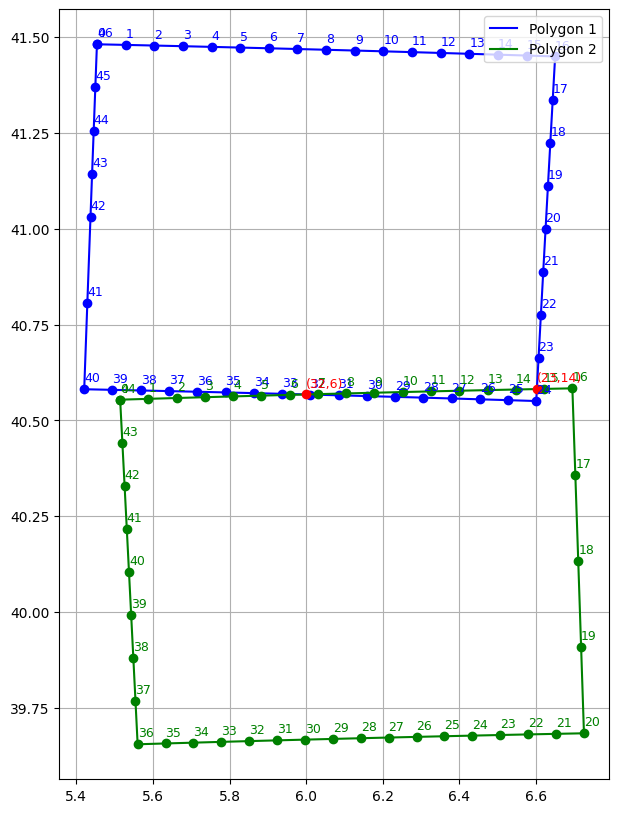

In [7]:
def polygon_edges_with_indices(coords):
    n = len(coords)
    return [(i, coords[i], coords[(i + 1) % n], LineString([coords[i], coords[(i + 1) % n]])) for i in range(n)]

def find_edge_intersections(polygon1_coords, polygon2_coords):
    origin_x = polygon1_coords[0][0]
    origin_y = polygon1_coords[0][1]
    edges1 = polygon_edges_with_indices([(x-origin_x, y-origin_y) for x, y in polygon1_coords])
    edges2 = polygon_edges_with_indices([(x-origin_x, y-origin_y) for x, y in polygon2_coords])

    edge2_geoms = [edge for _, _, _, edge in edges2]
    strtree = STRtree(edge2_geoms)

    intersections = []
    for i1, a1, a2, edge1 in edges1:
        candidates_idx = strtree.query(edge1)  # Now returns indices (np.ndarray)
        for idx in candidates_idx:
            edge2 = edge2_geoms[idx]
            intersection = edge1.intersection(edge2)
            if intersection.is_empty:
                continue
            if intersection.geom_type == 'Point':
                if (intersection.x == a1[0] and intersection.y == a1[1]) or (intersection.x == a2[0] and intersection.y == a2[1]):
                    # Don't care about intersections that happen exactly at a vertex (a bit risky but works nearly always)
                    continue
                i2 = idx  # idx corresponds to edge2 index
                intersection_x, intersection_y = round_coordinates(intersection.x, intersection.y, densified_binary_precision)
                intersections.append(((origin_x + intersection_x, origin_y + intersection_y), i1, int(i2)))  # Returned in poly1 order

    return intersections


def plot_example_polygons(tile_id1 = "31TGF"):
    poly1_coords = tiles[tile_id1]["dense_wgs84_polygon"].exterior.coords
    poly2_coords = tiles[list(intersect_graph.neighbors(tile_id1))[4]]["dense_wgs84_polygon"].exterior.coords

    intersections = find_edge_intersections(poly1_coords, poly2_coords)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot polygon1 edges and vertices
    for i, p1, p2, edge in polygon_edges_with_indices(poly1_coords):
        x, y = zip(*edge.coords)
        ax.plot(x, y, 'b-', label='Polygon 1' if i == 0 else "")

    for i, (x, y) in enumerate(poly1_coords):
        ax.plot(x, y, 'bo')
        ax.text(x, y+0.02, f"{i}", color='blue', fontsize=9)

    # Plot polygon2 edges and vertices
    for i, p1, p2, edge in polygon_edges_with_indices(poly2_coords):
        x, y = zip(*edge.coords)
        ax.plot(x, y, 'g-', label='Polygon 2' if i == 0 else "")

    for i, (x, y) in enumerate(poly2_coords):
        ax.plot(x, y, 'go')
        ax.text(x, y+0.02, f"{i}", color='green', fontsize=9)

    # Plot intersection points and label with edge indices
    for (x, y), i1, i2 in intersections:
        ax.plot(x, y, 'ro')
        ax.text(x, y+0.02, f"({i1},{i2})", color='red', fontsize=9)

    # Finalize plot
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True)
    plt.show()

print("Example polygons and edge intersections")
plot_example_polygons()

* For polygons not in the same UTM zone, find the intersection points and add those points to both of the polygons. 

Finding edge intersection points


100%|██████████| 74641/74641 [00:34<00:00, 2157.86it/s]


Adding edge intersection points to polygons


100%|██████████| 74641/74641 [00:04<00:00, 18188.83it/s]


Added 118838 edge intersection points (these should no longer be plotted in red)


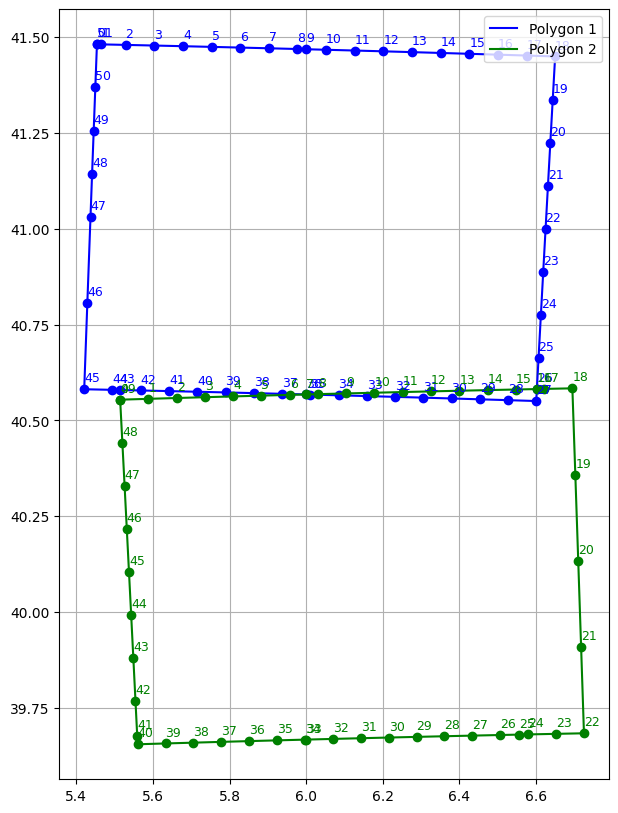

In [8]:
print("Finding edge intersection points")

additional_points = {}
for tile_id1 in tqdm(tiles.keys()):
    tile_id2s = filter(lambda tile_id2: tiles[tile_id1]["utm_zone"] < tiles[tile_id2]["utm_zone"], intersect_graph.neighbors(tile_id1))
    poly1_coords = tiles[tile_id1]["dense_wgs84_polygon"].exterior.coords
    if tile_id1 not in additional_points:
        additional_points[tile_id1] = {}        
    for tile_id2 in tile_id2s:
        poly2_coords = tiles[tile_id2]["dense_wgs84_polygon"].exterior.coords
        poly1_poly2 = find_edge_intersections(poly1_coords, poly2_coords)
        if tile_id2 not in additional_points:
            additional_points[tile_id2] = {}
        for (x, y), i1, i2 in poly1_poly2:
            additional_points[tile_id1][(x, y)] = i1
            additional_points[tile_id2][(x, y)] = i2

print("Adding edge intersection points to polygons")
num_additional_points = 0
for tile_id1, points2 in tqdm(additional_points.items()):
    coords = list(tiles[tile_id1]["dense_wgs84_polygon"].exterior.coords)
    edge_to_points2 = {}
    for point2, edge2 in points2.items():
        if edge2 not in edge_to_points2:
            edge_to_points2[edge2] = []
        edge_to_points2[edge2].append(point2)
    new_coords = []
    index2 = 0
    for index1 in range(len(coords) - 1):
        new_coords.append(coords[index1])
        points2 = edge_to_points2.get(index1, [])
        num_additional_points += len(points2)
        if len(points2) != 0:
            vec1 = (coords[index1 + 1][0] - coords[index1][0], coords[index1 + 1][1] - coords[index1][1])
            def key_f(a):
                vec2a = (a[0] - coords[index1][0], a[1] - coords[index1][1])
                cmpa = vec1[0]*vec2a[0] + vec1[1]*vec2a[1]
                return cmpa
            points2.sort(key=key_f)
            new_coords.extend(points2)
            if index1 == index2:
                None
    new_coords.append(coords[-1])
    tiles[tile_id1]["dense_wgs84_polygon"] = Polygon(new_coords)
            
print(f"Added {num_additional_points} edge intersection points (these should no longer be plotted in red)")
plot_example_polygons()

* Find and remove redundant polygons that are fully covered by other polygons.

Finding redundant tiles
Removing 32WNE


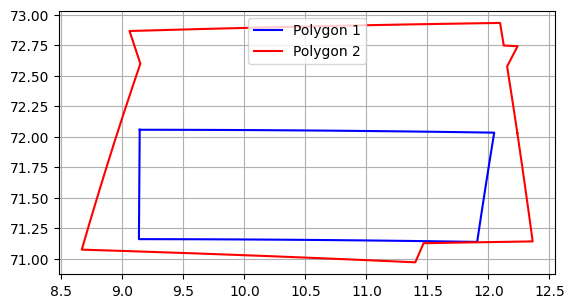

Removing 34WEE


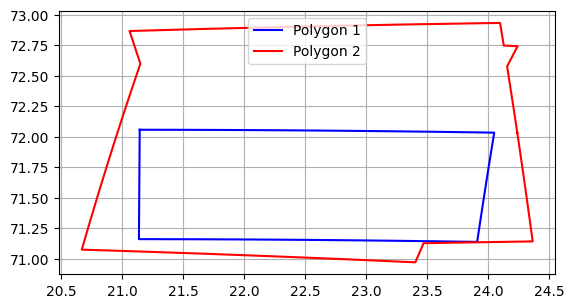

Removing 36WWE


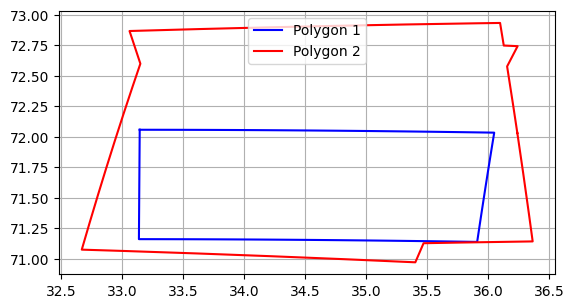

In [9]:
print("Finding redundant tiles")
for tile_id1, tile1 in list(tiles.items()):
    poly1 = tile1["dense_wgs84_polygon"]
    bounds1 = poly1.bounds
    minx1, miny1, maxx1, maxy1 = bounds1
    tile_ids2 = filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else [])
    polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
    if len(polys2) > 0:
        poly2 = unary_union(polys2)
        residual_poly1 = clean_geometry(poly1.difference(poly2))
        if residual_poly1.is_empty:
            print(f"Removing {tile_id1}")
            # Plot
            fig, ax = plt.subplots()
            x1, y1 = poly1.exterior.xy
            ax.plot(x1, y1, color='blue', label='Polygon 1')
            x2, y2 = poly2.exterior.xy
            ax.plot(x2, y2, color='red', label='Polygon 2')
            ax.set_aspect('equal')
            ax.legend()
            ax.grid(True)
            plt.show()            
            del tiles[tile_id1]
            intersect_graph.remove_node(tile_id1)


* Create copies of the polygons.
* For each pair of intersecting copy-polygons not in the same UTM zone, split the intersection at the mean central meridian of the copy-polygons, and donate the pieces to the polygons.

In [10]:
# Split intersections across UTM zones by splitting at the mean of the central meridian of the UTM zones.
print("Splitting intersections across UTM zones")
for tile_id1, tile1 in tiles.items():
    tile1["preferred_wgs84_polygon"] = tile1["dense_wgs84_polygon"]

for tile_id1, tile1 in tqdm(tiles.items()):
    poly1 = tile1["preferred_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["utm_zone"] != tile1["utm_zone"], intersect_graph.neighbors(tile_id1)))
    poly1_cutters = []
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["preferred_wgs84_polygon"]
        intersection = poly1.intersection(poly2)
        if intersection.area > 0:
            meridian2 = -180 + (tile2["utm_zone"]-1)*6 + 3
            mean_meridian = (meridian1 + meridian2)*0.5
            left_bbox = box(-180-360, -90, mean_meridian, 90)
            right_bbox = box(mean_meridian, -90, 180+360, 90)
            if meridian1 < meridian2:
                poly2_new = poly2.intersection(right_bbox)
            else:
                poly2_new = poly2.intersection(left_bbox)
            poly1_cutters.append(poly2_new)
    poly1_cutter = unary_union(poly1_cutters)
    poly1 = clean_geometry(poly1.difference(poly1_cutter))
    tile1["preferred_wgs84_polygon"] = poly1

Splitting intersections across UTM zones


100%|██████████| 74638/74638 [00:08<00:00, 8447.12it/s] 


* If the splitting has cut a polygon in two or more parts, and a part is fully covered by another polygon (before it was split), absorb the former into the latter.

Finding redundant partial tiles
Removing 32WPE poly 1/2


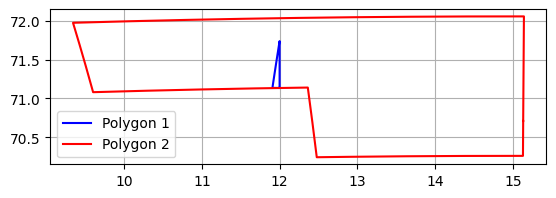

Removing 34WFE poly 1/2


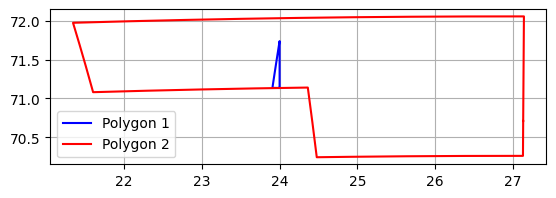

Removing 36WXE poly 1/2


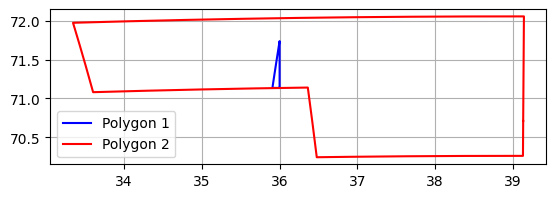

In [11]:
print("Finding redundant partial tiles")
removable_polys = {}
for tile_id1, tile1 in list(tiles.items()):
    geom1 = tile1["preferred_wgs84_polygon"]
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else []))
    polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
    if len(polys2) > 0:
        
        #poly2 = unary_union(polys2)
        polys2_union = unary_union(polys2)

        # Handle different geometry types
        if isinstance(geom1, MultiPolygon):
            polys1 = geom1.geoms
        elif isinstance(geom1, Polygon):
            polys1 = [geom1]
        else:
            print(f"Invalid geometry {tile_id1}")
        for index1, poly1 in enumerate(polys1):
            residual_poly1 = clean_geometry(poly1.difference(polys2_union))
            if residual_poly1.area == 0:
                print(f"Removing {tile_id1} poly {index1}/{len(polys1)}")
                # Plot
                fig, ax = plt.subplots()
                x1, y1 = poly1.exterior.xy
                ax.plot(x1, y1, color='blue', label='Polygon 1')
                x2, y2 = polys2_union.exterior.xy
                ax.plot(x2, y2, color='red', label='Polygon 2')
                ax.set_aspect('equal')
                ax.legend()
                ax.grid(True)
                tiles[tile_id1]["dense_wgs84_polygon"] = clean_geometry(tiles[tile_id1]["dense_wgs84_polygon"].difference(poly1))
                plt.show()


In [12]:
# Resplit intersections across UTM zones by splitting at the mean of the central meridian of the UTM zones.
print("Resplitting intersections across UTM zones")
for tile_id1, tile1 in tiles.items():
    tile1["preferred_wgs84_polygon"] = tile1["dense_wgs84_polygon"]

num_cut = 0
for tile_id1, tile1 in tqdm(tiles.items()):
    poly1 = tile1["preferred_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["utm_zone"] != tile1["utm_zone"], intersect_graph.neighbors(tile_id1)))
    poly1_cutters = []
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["preferred_wgs84_polygon"]
        intersection = poly1.intersection(poly2)
        if intersection.area > 0:
            num_cut += 1
            meridian2 = -180 + (tile2["utm_zone"]-1)*6 + 3
            mean_meridian = (meridian1 + meridian2)*0.5
            left_bbox = box(-180-369, -90, mean_meridian, 90)
            right_bbox = box(mean_meridian, -90, 180+360, 90)
            if meridian1 < meridian2:
                poly2_new = poly2.intersection(right_bbox)
            else:
                poly2_new = poly2.intersection(left_bbox)
            poly1_cutters.append(poly2_new)
    poly1_cutter = unary_union(poly1_cutters)
    poly1 = clean_geometry(poly1.difference(poly1_cutter))
    tile1["preferred_wgs84_polygon"] = poly1

print(f"Cut {num_cut} intersections")

Resplitting intersections across UTM zones


100%|██████████| 74638/74638 [00:08<00:00, 8505.55it/s]

Cut 51686 intersections


In [13]:
print("Finding redundant partial tiles again, should not find any")
removable_polys = {}
for tile_id1, tile1 in list(tiles.items()):
    geom1 = tile1["preferred_wgs84_polygon"]
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else []))
    polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
    if len(polys2) > 0:
        
        #poly2 = unary_union(polys2)
        polys2_union = unary_union(polys2)

        # Handle different geometry types
        if isinstance(geom1, MultiPolygon):
            polys1 = geom1.geoms
        elif isinstance(geom1, Polygon):
            polys1 = [geom1]
        else:
            print(f"Invalid geometry {tile_id1} of type {type(geom1)}")
        for index1, poly1 in enumerate(polys1):
            residual_poly1 = clean_geometry(poly1.difference(polys2_union))
            if residual_poly1.area == 0:
                print(f"Removing {tile_id1} poly {index1}/{len(polys1)}")
                # Plot
                fig, ax = plt.subplots()
                x1, y1 = poly1.exterior.xy
                ax.plot(x1, y1, color='blue', label='Polygon 1')
                x2, y2 = polys2_union.exterior.xy
                ax.plot(x2, y2, color='red', label='Polygon 2')
                ax.set_aspect('equal')
                ax.legend()
                ax.grid(True)
                tiles[tile_id1]["dense_wgs84_polygon"] = clean_geometry(tiles[tile_id1]["dense_wgs84_polygon"].difference(poly1))
                plt.show()


Finding redundant partial tiles again, should not find any


In [14]:
# Verify that we have no more overlaps
print("Looking for remaining overlaps (should not be any)")
plot_count = 10
num_nonzero = 0
max_area = 0
max_area_tile_id1 = None
max_area_tile_id2 = None
for tile_id1, tile1 in tiles.items():
    poly1 = tile1["preferred_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = filter(lambda tile_id2: tile_id1 < tile_id2, intersect_graph.neighbors(tile_id1))
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["preferred_wgs84_polygon"]
        area = poly1.intersection(poly2).area
        if area > 0:
            if type(poly1) == Polygon and type(poly2) == Polygon:
                if plot_count > 0:
                    print(f"Showing area {area} between {tile_id1} and {tile_id2}{"" if plot_count > 1 else " (too many plots, stopping after this)"}")

                    # Create figure and axis
                    fig, ax = plt.subplots()

                    # Plot poly1
                    x1, y1 = poly1.exterior.coords.xy
                    ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)

                    # Plot poly2
                    x2, y2 = poly2.exterior.coords.xy
                    ax.plot(x2, y2, color='red', label='Polygon 2', marker="x", alpha=0.25)

                    # Set equal aspect ratio
                    #ax.set_aspect('equal')

                    # Add legend and grid
                    ax.legend()
                    ax.grid(True)

                    #ax.set_xlim(-2.9, -2.89)
                    #ax.set_ylim(-64.955, -64.953)

                    # Show plot
                    plt.show()                
                    plot_count -= 1
                if area > max_area:
                    max_area = area
                    max_area_tile_id1 = tile_id1
                    max_area_tile_id2 = tile_id2
                num_nonzero += 1
print(f"Total num nonzero areas: {num_nonzero} (max area {max_area})")


Looking for remaining overlaps (should not be any)
Total num nonzero areas: 0 (max area 0)


In [15]:
# Debug plotting in case there are still overlaps
if max_area != 0:
    print(f"Showing geometries {max_area_tile_id1} and {max_area_tile_id2} with maximum intersection area {max_area}")
    print("(Note: endpoints are plotted twice)")
    id1 = max_area_tile_id1
    id2 = max_area_tile_id2
    display(list(tiles[id1]["preferred_wgs84_polygon"].exterior.coords))
    display(list(tiles[id2]["preferred_wgs84_polygon"].exterior.coords))

    poly1 = tiles[id1]["preferred_wgs84_polygon"]
    poly2 = tiles[id2]["preferred_wgs84_polygon"]

    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot poly1
    x1, y1 = poly1.exterior.coords.xy
    ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)

    # Plot poly2
    x2, y2 = poly2.exterior.coords.xy
    ax.plot(x2, y2, color='red', label='Polygon 2', marker="x", alpha=0.25)

    # Set equal aspect ratio
    #ax.set_aspect('equal')

    # Add legend and grid
    ax.legend()
    ax.grid(True)

    #ax.set_xlim(-2.9, -2.89)
    #ax.set_ylim(-64.955, -64.953)

    # Show plot
    plt.show()

In [16]:
print("Saving unclipped polygons (for debugging purposes)")
output_geojson = {
    "type": "FeatureCollection",
    "features": []
}
for tile_id, tile in tqdm(list(tiles.items())):
    # Project utm polygon to WGS84 without densification
    geom = tile["preferred_wgs84_polygon"]
    if type(geom) == Polygon:
        geoms = [geom]
    elif type(geom) == MultiPolygon:
        geoms = geom.geoms
    else:
        continue
    for index, geom in enumerate(geoms):
        wgs84_coords = []
        utm_coords = []
        for x, y in geom.exterior.coords:
            wgs84_coords.append((x, y))
            new_x, new_y = from_wgs84[tile["epsg_code"]](x, y)
            utm_coords.append((new_x, new_y))
        feature = {
            "type": "Feature",
            "properties": {
                "id": tile["id"] if len(geoms) == 1 else f"{tile["id"]}_{index}",
                "tile_id": tile_id,
                "epsg": tile["epsg_code"],
                "utm_area": Polygon(utm_coords).area
            },
            "geometry": mapping(orient(Polygon(wgs84_coords)))
        }
        output_geojson["features"].append(feature)
with open("unclipped_tiles.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)

Saving unclipped polygons (for debugging purposes)


100%|██████████| 74638/74638 [00:11<00:00, 6411.02it/s]


In [17]:
print("Splitting non-clone polygons that cross the antimeridian")
# TODO: split using y_c = (x_1 - x_c)*(y_1 - y_0)/(x_0 - x_1) + y_1 with ordered x
num_split = 0
wgs84_bbox = box(-180, -90, 180, 90)
split_tiles = {}
for tile_id, tile in tqdm(list(filter(lambda item: item[0] not in clone_tiles, tiles.items()))):
    geom = tile["preferred_wgs84_polygon"]
    beyond_wgs84 = clean_geometry(geom.difference(wgs84_bbox))
    if beyond_wgs84.is_empty:
        split_tiles[tile_id] = {
            **tile,
            "tile_id": tile_id,
            "id": tile_id
        }
    else:
        split_tiles[f"{tile_id}_0"] = {
            **tile,
            "tile_id": tile_id,
            "id": f"{tile_id}_0",
            "preferred_wgs84_polygon": clean_geometry(geom.intersection(wgs84_bbox))
        }
        if tile_id == "01VCL":
            display(list(clean_geometry(geom.intersection(wgs84_bbox)).exterior.coords))
        split_tiles[f"{tile_id}_1"] = {
            **tile,
            "tile_id": tile_id,
            "id": f"{tile_id}_1",
            "preferred_wgs84_polygon": Polygon([(x + 360 if tile["utm_zone"] < 30 else x - 360, y) for x, y in beyond_wgs84.exterior.coords])
        }
        num_split += 1
print(f"Split {num_split} polygons")

Splitting non-clone polygons that cross the antimeridian


  0%|          | 0/56683 [00:00<?, ?it/s]

100%|██████████| 56683/56683 [00:01<00:00, 43937.49it/s]

Split 108 polygons


In [21]:
def plot_example_polygon(tile_id1 = "01VCL"):
    poly1_coords = tiles[tile_id1]["preferred_wgs84_polygon"].exterior.coords
    poly2_coords = split_tiles[f"{tile_id1}_0"]["preferred_wgs84_polygon"].exterior.coords

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot polygon1 edges and vertices
    for i, p1, p2, edge in polygon_edges_with_indices(poly1_coords):
        x, y = zip(*edge.coords)
        ax.plot(x, y, 'b-', label='Polygon 1' if i == 0 else "")

    for i, (x, y) in enumerate(poly1_coords):
        ax.plot(x, y, 'bo')
        ax.text(x, y+0.02, f"{i}", color='blue', fontsize=9)

    # Plot polygon2 edges and vertices
    for i, p1, p2, edge in polygon_edges_with_indices(poly2_coords):
        x, y = zip(*edge.coords)
        ax.plot(x, y, 'b-', label='Polygon 2' if i == 0 else "")

    for i, (x, y) in enumerate(poly2_coords):
        ax.plot(x, y, 'bo')
        ax.text(x, y+0.02, f"{i}", color='magenta', fontsize=9)

    # Finalize plot
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True)
    plt.show()

#plot_example_polygon("01VCL")
#display(list(tiles["01VCL"]["preferred_wgs84_polygon"].exterior.coords))

In [22]:
print("Finding remaining edge intersection points")
additional_point_utm_zones = {}
num_additional_points = 0
for tile_id, tile in tqdm(list(tiles.items())):
    # Project utm polygon to WGS84 without densification
    geom = tile["preferred_wgs84_polygon"]
    for xy in geom.exterior.coords:
        if xy in additional_points[tile_id]:
            if xy not in additional_point_utm_zones:
                additional_point_utm_zones[xy] = {}
            additional_point_utm_zones[xy][tile["utm_zone"]] = True
            num_additional_points += 1

print(f"Found {num_additional_points} edge intersection points")
print(f"Removing those edge intersection points that are not shared between UTM zones")
num_unused_additional_points = 0
for tile_id, tile in tqdm(list(tiles.items())):
    # Project utm polygon to WGS84 without densification
    geom = tile["preferred_wgs84_polygon"]
    new_coords = []
    for xy in geom.exterior.coords:
        if xy in additional_points[tile_id]:
            if len(additional_point_utm_zones[xy]) == 1:
                num_unused_additional_points += 1
                continue
        new_coords.append(xy)
    tiles[tile_id]["preferred_wgs84_polygon"] = Polygon(new_coords)

print(f"Removed {num_unused_additional_points} unnecessary edge intersection points")

Finding remaining edge intersection points


100%|██████████| 74638/74638 [00:01<00:00, 46134.19it/s]


Found 88081 edge intersection points
Removing those edge intersection points that are not shared between UTM zones


100%|██████████| 74638/74638 [00:03<00:00, 19108.24it/s]

Removed 59407 unnecessary edge intersection points


In [ ]:
# Optional, not needed if there are no remaining overlaps
if False:
    print("Donating residual intersections to alphabetically earlier/later tiles")
    donate_to_earlier = True
    while True:
        num_donated = 0
        for tile_id1, tile1 in tiles.items():
            poly1 = tile1["preferred_wgs84_polygon"]
            tile_ids2 = list(filter(lambda tile_id2: tile_id1 < tile_id2, intersect_graph.neighbors(tile_id1)))
            for tile_id2 in tile_ids2:
                tile2 = tiles[tile_id2]
                poly2 = tile2["preferred_wgs84_polygon"]
                intersection = poly1.intersection(poly2)
                if intersection.area > 0:
                    print(intersection.area)
                    # Donate intersection to poly1
                    if donate_to_earlier:
                        poly2 = clean_geometry(poly2.difference(poly1))
                        tile2["preferred_wgs84_polygon"] = poly2
                    else:
                        poly1 = clean_geometry(poly1.difference(poly2))
                        tile1["preferred_wgs84_polygon"] = poly1
                    donate_to_earlier = not donate_to_earlier    
                    num_donated += 1
        print(f"Donated {num_donated} intersections")
        if num_donated == 0:
            break

In [ ]:
# Save clipped polygons
output_geojson = {
    "type": "FeatureCollection",
    "features": []
}
for tile_id, tile in tqdm(list(split_tiles.items())):
    # Project utm polygon to WGS84 without densification
    geom = tile["preferred_wgs84_polygon"]
    if type(geom) == Polygon:
        geoms = [geom]
    elif type(geom) == MultiPolygon:
        geoms = geom.geoms
    else:
        continue
    for index, geom in enumerate(geoms):
        wgs84_coords = []
        utm_coords = []
        for x, y in geom.exterior.coords:
            wgs84_coords.append((x, y))
            new_x, new_y = from_wgs84[tile["epsg_code"]](x, y)
            utm_coords.append((new_x, new_y))
        feature = {
            "type": "Feature",
            "properties": {
                "id": tile["id"] if len(geoms) == 1 else f"{tile["id"]}_{index}",
                "tile_id": tile["tile_id"],
                "epsg": tile["epsg_code"],
                "utm_area": Polygon(utm_coords).area
            },
            "geometry": mapping(orient(Polygon(wgs84_coords)))
        }
        output_geojson["features"].append(feature)
with open("preferred_tiles_17.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)

100%|██████████| 56791/56791 [00:08<00:00, 6853.93it/s]
